In [6]:
import pandas as pd
import numpy as np
import glob
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
files = glob.glob('/Users/rakesh/Downloads/emails/*')


In [8]:
df=pd.DataFrame()
df['email']=''

In [9]:
l=[]
for i in files:
    with open(i,'rb') as fp:
        line = fp.readline()
        cnt = 1
        while line:
            if cnt ==2:
                l.append(line.strip())
            #print("Line {}: {}".format(cnt, line.strip()))
            line = fp.readline()
            cnt += 1

In [10]:
df['email']=l

In [11]:
df['email']=df['email'].astype(str)

In [12]:
# Convert to list
data = df.email.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", str(sent).lower()) for sent in data]
data = [re.sub("subject", "", sent) for sent in data]
data = [re.sub("re", "", sent) for sent in data]
data = [re.sub("b", "", sent) for sent in data]
data = [re.sub(":", "", sent) for sent in data]




pprint(data[:1])

['  joe roie stadium "not for aseall"']


<>:5: DeprecationWarning: invalid escape sequence \S
<>:8: DeprecationWarning: invalid escape sequence \s
<ipython-input-12-9376d7d2c91c>:5: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-12-9376d7d2c91c>:8: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['joe', 'roie', 'stadium', 'not', 'for', 'aseall']]


In [15]:
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data_stop = list(remove_stopwords(data_words))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rakesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_stop, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])



In [17]:
print(data_lemmatized[:3])

['', 'pgnancy', 'opinion seek']


In [18]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [19]:
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.23850469308002928 %


In [20]:
lda_model = LatentDirichletAllocation(n_components=4,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1    # compute perplexity every n iters, default: Don't
                                                     # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=4,
                          random_state=100)


In [21]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -79770.93567863964
Perplexity:  349.4871878455496
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 4,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [22]:
search_params = {'n_components': [4, 6, 8], 'learning_decay': [.5, .7]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

/Users/rakesh/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:443: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/Users/rakesh/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:93: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
De

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7],
                         'n_components': [4, 6, 8]})

In [23]:
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 4}
Best Log Likelihood Score:  -17896.120183000065
Model Perplexity:  362.3942303981609


In [24]:
log_likelyhoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelyhoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]


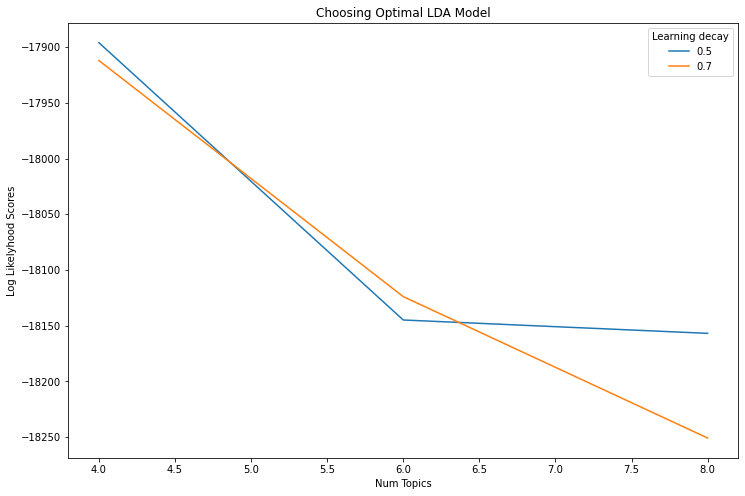

In [25]:
n_topics=[4,6,8]
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
#plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [51]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,dominant_topic
Doc0,0.250000,0.250000,0.250000,0.250000,0
Doc1,0.250000,0.250000,0.250000,0.250000,0
Doc2,0.080000,0.420000,0.420000,0.080000,1
Doc3,0.080000,0.080000,0.750000,0.080000,2
Doc4,0.250000,0.250000,0.250000,0.250000,0
Doc5,0.060000,0.810000,0.060000,0.060000,1
Doc6,0.250000,0.250000,0.250000,0.250000,0
Doc7,0.060000,0.810000,0.060000,0.060000,1
Doc8,0.080000,0.080000,0.090000,0.750000,3
Doc9,0.420000,0.080000,0.420000,0.080000,0


In [52]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,6051
1,1,2112
2,2,1606
3,3,1544


In [26]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/Users/rakesh/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/rakesh/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:57: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/rakesh/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavio

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      269.562408 -124.803398       1        1  25.940994
3        1.782994 -295.079681       2        1  25.234544
0      220.811432 -343.832123       3        1  25.021720
1       50.533993  -76.050934       4        1  23.802742, topic_info=             Term        Freq       Total Category  logprob  loglift
347      question  292.000000  292.000000  Default  30.0000  30.0000
175          help  250.000000  250.000000  Default  29.0000  29.0000
370          sale  232.000000  232.000000  Default  28.0000  28.0000
484          want  164.000000  164.000000  Default  27.0000  27.0000
272          need  254.000000  254.000000  Default  26.0000  26.0000
492        window  127.000000  127.000000  Default  25.0000  25.0000
39        atheist  116.000000  116.000000  Default  24.0000  24.0000
499          year  103.000000  103.000000  Default  23.0000  23.0000
340        prolem   99.000000   99.000000  Default  22.0000  22.0000
121         drive   89.000000   89.000000  Default  21.0000  21.0000
373           say   88.000000   88.000000  Default  20.0000  20.0000
63           code   86.000000   86.000000  Default  19.0000  19.0000
22   announcement   77.000000   77.000000  Default  18.0000  18.0000
263      morality   79.000000   79.000000  Default  17.0000  17.0000
451          time   77.000000   77.000000  Default  16.0000  16.0000
168           gun  138.000000  138.000000  Default  15.0000  15.0000
165          good  124.000000  124.000000  Default  14.0000  14.0000
55           chip   71.000000   71.000000  Default  13.0000  13.0000
229          look   76.000000   76.000000  Default  12.0000  12.0000
122        driver   74.000000   74.000000  Default  11.0000  11.0000
435           tap   73.000000   73.000000  Default  10.0000  10.0000
147          file   71.000000   71.000000  Default   9.0000   9.0000
205           key   69.000000   69.000000  Default   8.0000   8.0000
409         space   68.000000   68.000000  Default   7.0000   7.0000
478         video   68.000000   68.000000  Default   6.0000   6.0000
291       opinion   67.000000   67.000000  Default   5.0000   5.0000
130    encryption   64.000000   64.000000  Default   4.0000   4.0000
170          hard   64.000000   64.000000  Default   3.0000   3.0000
53          cheap   68.000000   68.000000  Default   2.0000   2.0000
445          text   63.000000   63.000000  Default   1.0000   1.0000
370          sale  232.233670  232.966709   Topic1  -2.7223   1.3462
484          want  163.446379  164.225902   Topic1  -3.0735   1.3446
340        prolem   98.569870   99.303357   Topic1  -3.5793   1.3419
229          look   75.652989   76.389657   Topic1  -3.8439   1.3397
53          cheap   67.907128   68.756334   Topic1  -3.9519   1.3369
354         ranch   47.019022   47.747409   Topic1  -4.3195   1.3340
469           urn   44.156011   44.883185   Topic1  -4.3823   1.3330
64          color   44.148813   44.883283   Topic1  -4.3825   1.3328
432      survivor   41.291475   42.018970   Topic1  -4.4494   1.3319
115      dividian   40.337506   41.064234   Topic1  -4.4727   1.3315
108      detector   40.337410   41.064236   Topic1  -4.4727   1.3315
483          waco   38.427872   39.154761   Topic1  -4.5212   1.3306
443          test   38.425150   39.154787   Topic1  -4.5213   1.3305
10         advice   38.424072   39.154775   Topic1  -4.5213   1.3305
30      arrogance   37.472640   38.200030   Topic1  -4.5464   1.3301
75       computer   34.600696   35.336007   Topic1  -4.6261   1.3283
235       machine   33.651086   34.381098   Topic1  -4.6540   1.3279
454         today   32.698187   33.426347   Topic1  -4.6827   1.3273
457     tradition   31.744789   32.471594   Topic1  -4.7123   1.3267
269        murder   31.744304   32.471613   Topic1  -4.7123   1.3267
139          exps   31.743699   32.471639   Topic1  -4.7123   1.3267
378       science   2

In [54]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,accept,acceptance,access,account,ackcountry,acking,activity,adds,ader,admission,...,win,window,wing,wiring,woman,word,work,wrong,year,young
Topic0,0.256658,0.250054,17.247332,0.250039,0.250094,0.250038,0.250093,0.252064,0.250181,0.251344,...,0.561419,0.253206,9.236245,17.239766,0.250286,11.404463,0.253945,0.251839,89.797412,0.250157
Topic1,0.250212,0.250045,0.250179,0.250036,12.249712,0.250032,0.250079,10.242992,0.251720,0.252279,...,61.937167,0.253043,6.187730,0.251617,15.247925,5.093125,60.231999,11.241868,0.252001,16.247225
Topic2,22.160463,19.249845,0.251418,10.249888,0.250100,0.250040,12.249734,0.251134,11.247916,0.250292,...,0.250286,132.239311,0.250516,0.250141,0.250305,0.252116,0.255958,0.252661,18.700213,0.251349
Topic3,19.332667,0.250055,0.251070,0.250036,0.250094,12.249890,0.250093,0.253810,0.250183,14.246085,...,0.251128,0.254440,5.325509,0.258477,0.251484,0.250296,0.258098,0.253632,0.250374,0.251269


In [55]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,atheist,prolem,say,year,morality,time,look,driver,political,christian,player,jewish,team,change,point
Topic 1,help,need,want,gun,card,new,file,key,graphic,opinion,israeli,win,work,control,update
Topic 2,sale,window,code,drive,tap,space,car,long,info,cheap,hard,detector,test,arrogance,disk
Topic 3,question,good,announcement,chip,use,video,encryption,text,need,line,monitor,source,warn,god,post


In [56]:
import pickle
pickle.dump(lda_model, open('/Users/rakesh/Downloads/Funnel leasing assignment/lda_topic.pkl','wb'))
